### Line density plot example 
Might for instance be used to plot the density of many time series

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# generate some signals
random_signal = lambda: np.linspace(-1, 1, 100) + np.random.normal(0, 1, 100)
data = [random_signal() for i in range(100000)]

# frame should contain one time series per column 
df = pd.DataFrame(data).T
df

,0,1,2,3,4,5,6,7,8,9,...,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
0,-0.554456,-2.421096,0.660928,0.250714,-3.969714,-1.418082,0.879018,-2.049192,-1.060902,0.425791,...,-0.561038,-0.363114,-1.132399,-1.816425,-1.803299,-0.139758,-1.520633,-1.584143,-1.049401,-1.647259
1,-1.177800,-1.732912,0.095777,-0.517055,-0.308435,0.791026,-0.211037,-0.881829,-2.280110,-0.891374,...,-1.125520,-1.723434,-2.182608,-0.071770,-3.516300,-2.784046,-0.823983,-0.382226,-0.203483,-0.672226
2,-0.423445,-0.637622,-1.236200,-0.275236,0.068513,-1.007733,-0.530542,0.190622,-1.245780,-0.116169,...,-0.148079,-1.262937,0.154782,-1.883346,-1.011467,-2.591224,-1.415509,-1.310132,-1.087244,-0.357729
3,-0.572182,0.147301,-1.009318,-0.024488,-2.131974,-1.671705,-0.984041,-0.605018,0.367793,-1.626255,...,-0.770486,-0.317190,0.755987,-0.985351,-2.316687,-0.264620,1.508131,-1.819335,-0.074074,-0.981428
4,0.057527,-1.915582,-0.886331,-2.247307,-1.202394,-2.201427,-1.681015,-1.253985,-0.024143,-1.366652,...,-0.868253,-1.665020,-1.672580,0.416863,-0.670868,1.365943,1.128251,-1.533746,-2.047413,-0.740649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.970558,-0.853426,1.094159,0.781185,0.741600,2.354976,1.901121,1.926489,1.869147,2.712281,...,1.108380,0.274250,0.422411,1.482577,1.676390,2.357987,2.087593,1.847485,2.934021,0.403501
96,1.339233,-0.787522,2.338711,0.986567,0.882679,-0.073869,-0.419467,2.514768,-0.270961,2.120214,...,0.081952,2.065792,3.979199,2.462551,0.786116,-1.015937,1.961170,2.006389,0.105336,2.168867
97,1.417704,2.726401,-1.339363,0.082981,-0.201858,0.822544,-0.851570,1.702381,1.326952,0.212658,...,1.680656,1.032718,-0.734457,1.019190,2.564349,1.142071,1.989892,0.326133,2.910227,-0.451666
98,0.168522,0.671347,1.176262,0.545795,0.132288,2.869758,1.331199,1.734588,3.288031,0.607273,...,0.720774,-0.840304,1.527255,-0.026486,0.233989,1.351562,0.743244,-0.148973,0.314853,1.809023


/media/storage/dev/shorelineforecasting/shorelineforecasting/venv/lib/python3.8/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


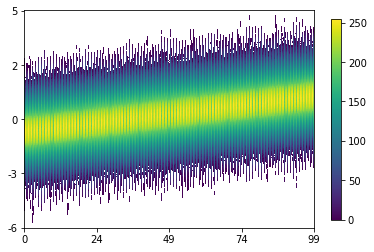

In [2]:
import datashader as ds
import datashader.transfer_functions as tfnc


# canvas settings
w = 1000
h = 750
dpi = 150


def plot_line_density(df, ax):
    # Each column is one data sample
    idx = df.index # keep index to format plot in later stage
    df = df.reset_index(drop=True)

    # Append row with nan-values (makes it apparently much faster)
    df = df.append(pd.DataFrame([np.array([np.nan] * len(df.columns))], columns=df.columns, index=[np.nan]))

    # Reshape
    x, y = df.shape
    arr = df.values.reshape((x * y, 1), order='F')
    df_reshaped = pd.DataFrame(arr, columns=list('y'), index=np.tile(df.index.values, y))
    df_reshaped = df_reshaped.reset_index()
    df_reshaped.columns.values[0] = 'x'

    # Create canvas
    x_range = (min(df.index.values), max(df.index.values))
    y_range = (df.min().min(), df.max().max())
    cvs = ds.Canvas(x_range=x_range, y_range=y_range, plot_height=h, plot_width=w)

    # Aggregate to heatmap
    aggs = cvs.line(df_reshaped, 'x', 'y', ds.count())
    heatmap_img = tfnc.Image(tfnc.shade(aggs, cmap=plt.cm.viridis))

    # plot
    im = ax.imshow(heatmap_img.to_pil())
    cbar = fig.colorbar(im, fraction=0.03, pad=0.05) #TODO: not pixel value but count of time series
    
    # re-format axes
    ax.set_xticks(np.linspace(0, w, 5))
    ax.set_yticks(np.linspace(h, 0, 5))
    ax.set_xticklabels(np.linspace(idx[0], idx[-1], 5).astype(int))
    ax.set_yticklabels(np.linspace(np.nanmin(df.values), np.nanmax(df.values), 5).astype(int))
    return ax


fig, ax = plt.subplots()    
plot_line_density(df, ax)
